In [37]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Fetching the data

In [21]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", parser="auto")
X, y = mnist.data.to_numpy(), mnist.target.to_numpy()
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

# Visualizing the data

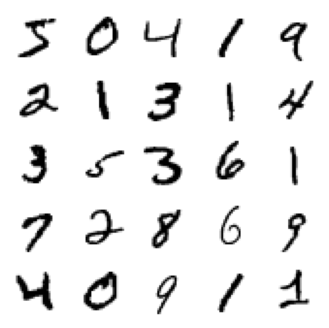

In [22]:
fig, axes = plt.subplots(5, 5, figsize=(4, 4))
for row in range(0, 5):
    for col in range(0, 5):
        axes[row, col].imshow(X[row * 5 + col].reshape((28, 28)), cmap="binary")
        axes[row, col].set_axis_off()

# Training a binary classifier of all 5s

In [23]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [24]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
display()

In [25]:
res = sgd_clf.predict(X_train[:25].reshape(25, -1))
np.array(list(map(lambda x: 5 if x else 0, res))).reshape(5, 5)

array([[5, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

## 3-fold Cross Validation

In [26]:
print("Possible scoring options for cross_validation and cross_val_score:\n")
print(", ".join(sklearn.metrics.get_scorer_names()))

Possible scoring options for cross_validation and cross_val_score:

accuracy, adjusted_mutual_info_score, adjusted_rand_score, average_precision, balanced_accuracy, completeness_score, explained_variance, f1, f1_macro, f1_micro, f1_samples, f1_weighted, fowlkes_mallows_score, homogeneity_score, jaccard, jaccard_macro, jaccard_micro, jaccard_samples, jaccard_weighted, matthews_corrcoef, max_error, mutual_info_score, neg_brier_score, neg_log_loss, neg_mean_absolute_error, neg_mean_absolute_percentage_error, neg_mean_gamma_deviance, neg_mean_poisson_deviance, neg_mean_squared_error, neg_mean_squared_log_error, neg_median_absolute_error, neg_negative_likelihood_ratio, neg_root_mean_squared_error, normalized_mutual_info_score, positive_likelihood_ratio, precision, precision_macro, precision_micro, precision_samples, precision_weighted, r2, rand_score, recall, recall_macro, recall_micro, recall_samples, recall_weighted, roc_auc, roc_auc_ovo, roc_auc_ovo_weighted, roc_auc_ovr, roc_auc_ovr_wei

In [27]:
from sklearn.model_selection import cross_validate
pd.DataFrame(cross_validate(sgd_clf, X_train, y_train_5, cv=3, scoring=["accuracy", "recall", "precision", "positive_likelihood_ratio"]))

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_positive_likelihood_ratio
0,6.630692,0.046194,0.95035,0.470393,0.959368,237.718287
1,6.262082,0.042882,0.96035,0.639734,0.890601,81.962587
2,4.844838,0.046215,0.96040,0.843387,0.749631,30.144866


## Comparing with a dummy classifier

In [28]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier

d_clf = DummyClassifier(random_state=42)
d_clf.fit(X_train, y_train_5)
res = d_clf.predict(X_train[:25].reshape(25, -1))
pd.DataFrame(cross_validate(d_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

,fit_time,score_time,test_score
0,0.109621,0.001403,0.90965
1,0.121404,0.001147,0.90965
2,0.105119,0.001204,0.90965


## Calculating the confusion matrix

In [57]:
from sklearn.model_selection import cross_val_predict
# Why do I need to send y_train_5?
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [55]:
pd.DataFrame(np.vstack([y_train_5, y_train_pred]).T, columns=["y", "y_hat"])

,y,y_hat
0,True,True
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
59995,False,False
59996,False,False
59997,True,True
59998,False,False


In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("Precision: {}".format(precision_score(y_train_5, y_train_pred)))
print("Recall: {}".format(recall_score(y_train_5, y_train_pred)))
print("F1: {}".format(f1_score(y_train_5, y_train_pred)))

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1: 0.7325171197343846


## Demonstration of threshold

In [32]:
sgd_clf.decision_function(X_train[:25]).reshape(5, 5)

array([[  2164.22030239,  -5897.37359354, -13489.14805779,
         -4623.84515943,  -6873.05248453],
       [ -3908.27576291,  -4851.9422397 ,  -4988.52407755,
         -2226.78132866,  -4081.33692831],
       [ -5711.47789687,   4742.52813158, -10322.61970087,
         -5028.5080424 ,  -2774.48933701],
       [ -4757.62175338,  -7995.78737908,  -5478.98084419,
         -2494.25572149,  -8689.98448487],
       [-22773.42525493,   -758.37177086,  -5694.60529267,
         -4975.03617479,  -1371.18472762]])

In [58]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [85]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_train_5, y_scores)
precision_recall_table = pd.DataFrame(dict(threshold=threshold, precision=precision[:-1], recall=recall[:-1]))
precision_recall_table

,threshold,precision,recall
0,-146348.567262,0.090350,1.000000
1,-142300.007054,0.090352,1.000000
2,-137588.975817,0.090353,1.000000
3,-137155.626441,0.090355,1.000000
4,-136254.058562,0.090356,1.000000
...,...,...,...
59995,36801.606970,1.000000,0.000922
59996,37026.251165,1.000000,0.000738
59997,38871.263919,1.000000,0.000553
59998,42216.055628,1.000000,0.000369


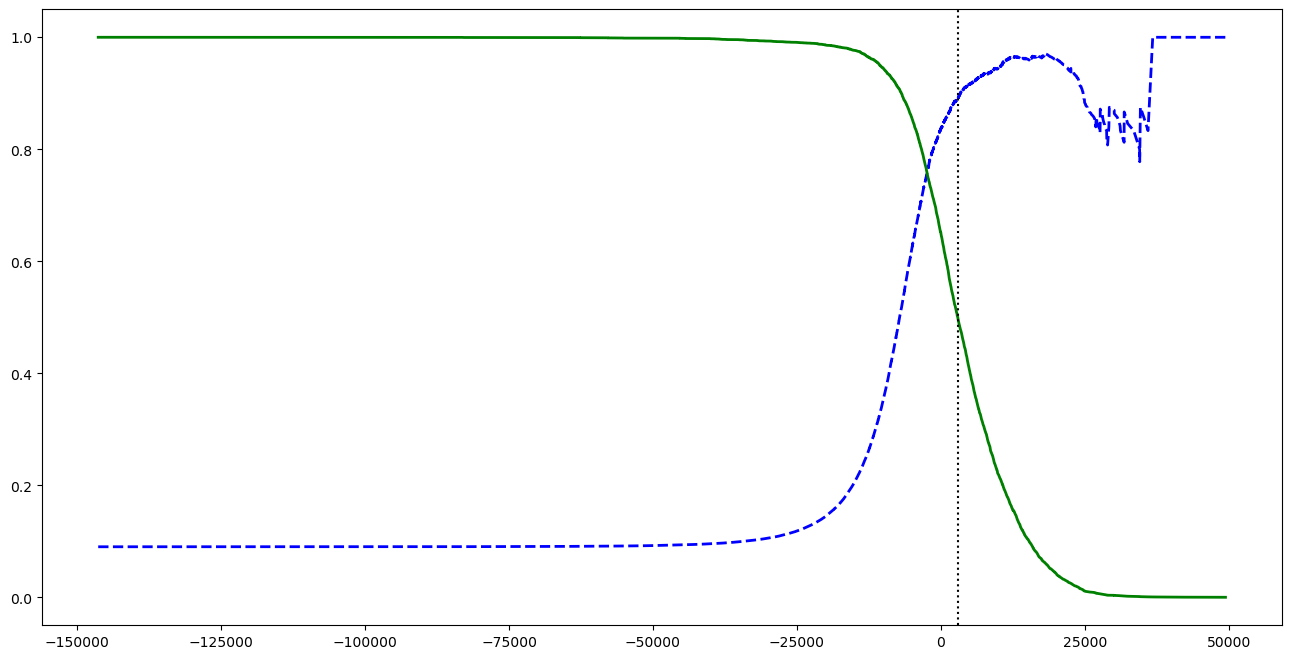

In [100]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(threshold, precision[:-1], "b--", label="Precision", linewidth=2)
ax.plot(threshold, recall[:-1], "g-", label="Recall", linewidth=2)
ax.axvline?
ax.axvline(3000, 0, 1.0, c="k", ls="dotted")
display()